## Example 1: Second-order reaction, well-mixed simulation 

example script: ex1_reac.py

Model checking:
Warnings:
SC in cyt is only ever present on the RHS of reactions.
Model checking:
Warnings:
SC in cyt is only ever present on the RHS of reactions.


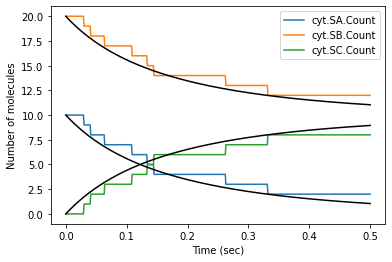

In [1]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Example 1: Second-order reaction, well-mixed simulation 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Import the new steps interface
import steps.interface

# Import biochemical model module
from steps.model import *

# Create model container
mdl = Model()

# Create reaction manager
r = ReactionManager()

# Using this model, declare species and reactions
with mdl:
    # Create chemical species
    SA, SB, SC  = Species.Create()

    # Create reaction set container
    vsys = VolumeSystem.Create()

    with vsys:
        # Create reaction
        # SA + SB - > SC with rate 200 /uM.s
        SA + SB >r[1]> SC
        r[1].K = 200e6

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Import geometry module
from steps.geom import *

# Create well-mixed geometry container
wmgeom = Geometry()

# Using this geometry, declare compartments
with wmgeom:
    # Create cytosol compartment, associate it with vsys, give volume in m^3
    cyt = Compartment.Create(vsys, vol=1e-18)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Import random number generator module
from steps.rng import *

# Create random number generator, with buffer size as 256 and starting seed 899
rng = RNG('mt19937', 256, 899)

# Could use time to get random seed
# import time
# rng = RNG('mt19937', 256, int(time.time()))

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Import simulation and data saving modules
from steps.sim import *
from steps.saving import *

# Create well-mixed stochastic simulation object
sim_wm = Simulation('Wmdirect', mdl, wmgeom, rng)

# Create a result selector associated to the sim_wmulation
rs = ResultSelector(sim_wm)

# Specify which values should be saved, here all species counts in compartment "cyt"
counts_wm = rs.cyt.ALL(Species).Count

# Save these values every 0.001s
sim_wm.toSave(counts_wm, dt=0.001)

# Signalize the start of a new run
sim_wm.newRun()

# Initialize the number of 'A' molecules to 10
sim_wm.cyt.SA.Count = 10

# Or you can set the concentration (M), as for 'B'
sim_wm.cyt.SB.Conc = 3.32e-08

# Run sim_wmulation until 0.5s, data is recorded automatically
sim_wm.run(0.5)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Create well-mixed deterministic solver
sim_rk4 = Simulation('Wmrk4', mdl, wmgeom, rng)

# Set the integration time-step (s)
sim_rk4.setRk4DT(0.00001)

# Declare values to be saved for the deterministic solver
rs = ResultSelector(sim_rk4)
counts_rk4 = rs.cyt.ALL(Species).Count
sim_rk4.toSave(counts_rk4, dt=0.001)

# Repeat the simulation process for the deterministic solver
sim_rk4.newRun()
sim_rk4.cyt.SA.Count = 10
sim_rk4.cyt.SB.Conc = 3.32e-08
sim_rk4.run(0.5)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Import matplotlib via pylab
from pylab import *

# Use Matlpotlib functions to plot data from both simulations
# Note that we access data from run 0
plot(counts_wm.time[0], counts_wm.data[0])
plot(counts_rk4.time[0], counts_rk4.data[0], color='black')

ylabel('Number of molecules')
xlabel('Time (sec)')
legend(counts_wm.labels)
show()

## Example 2: Surface reactions: IP3 receptor model 

### 1. Biochemical model and geometry
example script: ex2_ip3model.py

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Example 2: Surface reactions: IP3 receptor model 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

import steps.interface

from steps.model import *
from steps.geom import *

###############################################################################

def getModel():

    # Create model container object
    mdl = smodel.Model()
    
    # Chemical species
    Ca, IP3, = Species.Create() # Calcium and IP3
    
    # Receptor state objects
    R     = Species.Create() # IP3 receptor in 'naive' state
    RIP3  = Species.Create() # bound IP3 
    Ropen = Species.Create() # bound IP3 and Ca (open)
    RCa   = Species.Create() # 1 bound Ca to inactivation site
    R2Ca  = Species.Create() # 2 bound Ca to inactivation sites
    R3Ca  = Species.Create() # 3 bound Ca to inactivation sites
    R4Ca  = Species.Create() # 4 bound Ca to inactivation sites
    
    surfsys = SurfaceSystem.Create()

    with surfsys:
        # The binding reactions:
        R.s + IP3.o   <r[1]> RIP3.s
        RIP3.s + Ca.o <r[2]> Ropen.s
        R.s + Ca.o    <r[3]> RCa.s
        RCa.s + Ca.o  <r[4]> R2Ca.s
        R2Ca.s + Ca.o <r[5]> R3Ca.s
        R3Ca.s + Ca.o <r[6]> R4Ca.s

        # The reaction constants
        r[1].K = 1000000000.0, 25800.0
        r[2].K = 8000000000.0, 2000.0
        r[3].K = 8889000.0, 5.0
        r[4].K = 20000000.0, 10.0
        r[5].K = 40000000.0, 15.0
        r[6].K = 60000000.0, 20.0

        # Ca ions passing through open IP3R channel
        Ca.i + Ropen.s <r[1]> Ropen.s + Ca.o
        # Corresponds to Ca input ~ 20000/ms for open receptor
        r[1].K = 8000000.0, 8000000.0

    # return model container object
    return mdl

###############################################################################

def getGeom(mdl):

    geom = Geometry()
    with geom:
        # Create cytosol compartment
        cyt = Compartment.Create()
        # Assign volume to cytosol 
        cyt.Vol = 1e-19
        
        # Create ER compartment
        ER = Compartment.Create()
        # Assign volume to ER 
        ER.Vol = 2e-20
        
        # Create the ER membrane and associate it with a surface system
        ERmemb = Patch.Create(ER, cyt, mdl.surfsys)

    # return geometry container object
    return geom

###############################################################################

### 2. Simulation
example script: ex2_sim.py

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Example 2: Surface reactions: IP3 receptor model 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

import steps.rng as srng
import steps.solver as ssolver

from pylab import *
%matplotlib inline

import ex2_ip3model as ip3r_model 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Simulation control variables
NITER = 100
T_END = 0.201
DT = 0.001
POINTS = int(T_END/DT)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Import model
mdl = ip3r_model.getModel()

# Import geometry 
geom = ip3r_model.getGeom()

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Create random number generator
r = srng.create('mt19937', 512)
r.initialize(654)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Create well-mixed solver object
sim = ssolver.Wmdirect(mdl, geom, r)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Create Numpy array data structures
tpnt = arange(0.0, T_END, DT)
res_m = zeros([NITER, POINTS, 2])
res_std1 = zeros([POINTS, 2])
res_std2 = zeros([POINTS, 2])

# Run the simulation
for i in range (0, NITER):
    
    # Reset the simulation object
    sim.reset()
    
    # Set initial conditions
    sim.setCompConc('cyt', 'Ca', 3.30657e-8)               
    sim.setCompConc('cyt', 'IP3', 2.5e-6)   
    sim.setCompConc('ER', 'Ca', 150e-6)
    sim.setPatchCount('memb', 'R', 16)
    
    # Clamp ER calcium to fixed concentration
    sim.setCompClamped('ER', 'Ca', True)
        
    for t in range(0,POINTS):
        sim.run(tpnt[t])            
        
        # Record data
        res_m[i,t,0] = sim.getCompConc('cyt', 'Ca')*1e6		
        res_m[i,t,1] = sim.getPatchCount('memb', 'Ropen')

print ("Ran ", NITER, "sim iterations ")

# Numpy array manipulation
mean_res = mean(res_m, 0)
std_res = std(res_m, 0)

def plotCa():
    # Matplotlib plotting functions
    plot(tpnt, mean_res[:,0], color = 'black', \
        linewidth = 1.0, label = 'mean')
    res_std1 = mean_res[:,0] + std_res[:,0]
    res_std2 = mean_res[:,0]- std_res[:,0]

    plot(tpnt, res_std1, color = 'gray', linewidth = 0.5, \
        label = 'standard deviation')
    plot(tpnt, res_std2,color = 'gray', linewidth = 0.5)

    xlabel('Time (sec)')
    ylabel('cytosolic Ca concentration ($\mu$M)')
    title('%d iterations' %NITER)
    ylim(0)
    legend()
    show()

def plotIP3R():
    # Matplotlib plotting functions
    plot(tpnt, mean_res[:,1], color = 'black', \
        linewidth = 1.0, label = 'mean')
    res_std1 = mean_res[:,1] + std_res[:,1]
    res_std2 = mean_res[:,1]- std_res[:,1]

    plot(tpnt, res_std1, color = 'gray', linewidth = 0.5, \
        label = 'standard deviation')
    plot(tpnt, res_std2,color = 'gray', linewidth = 0.5)

    xlabel('Time (sec)')
    ylabel('# open receptors')
    title('%d iterations' %NITER)
    ylim(0)
    legend()
    show()

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Let's run the simulation:

In [ ]:
import ex2_sim
ex2_sim.plotCa()
ex2_sim.plotIP3R()

## Example 3: Unbounded diffusion 
example script: ex3_diff.py

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Example 3: Unbounded diffusion 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

import math
import time

from pylab import *

import steps.model as smodel
import steps.solver as solvmod
import steps.utilities.meshio as meshio 
import steps.geom as stetmesh
import steps.rng as srng

########################################################################

# Number of iterations; plotting dt; sim endtime:
NITER = 10
DT = 0.001
INT = 0.2

# The Abaqus file to import
MESHFILE = 'sp_10r_3875'

# The diffusion constant
DCST = 0.02e-9

# Number of molecules injected in centre 
NINJECT = 1000    

# The number of tetrahedrons to sample, selected at random
SAMPLE = 500    

# Create the array of tet indices to be found at random
tetidxs = zeros(SAMPLE, dtype = 'int')

# Further create the array of tet barycentre distance to centre
tetrads = zeros(SAMPLE)

# Make random number generator avaialble for initial conditions
rng = srng.create('mt19937', 256) 
rng.initialize(123) 

########################################################################

beg_time = time.time()

# Function to plot simulation run time
def printtime(end_time):

    totsecs = int(end_time-beg_time)
    sec = totsecs%60
    totmin = totsecs/60
    min = totmin%60
    hours = totmin/60
    
    print ('Simulation time: %d h, %d min, %d sec' %(hours, min, sec))
    
########################################################################

def gen_model():
   
    # Create model container object 
    mdl = smodel.Model()
    
    # Create species 'X'
    X = smodel.Spec('X', mdl)
    
    # Create volume system               
    cytosolv = smodel.Volsys('cytosolv', mdl)
    
    # Create diffusion rule
    dif_X = smodel.Diff('diffX', cytosolv, X,  DCST)

    return mdl
    
########################################################################

def gen_geom(meshfile):
    print ("Loading mesh...")
    mesh = meshio.importAbaqus('meshes/'+meshfile, 1.0e-6)[0]
    print ("Mesh loaded.")
    
    ntets = mesh.countTets()
    
    # Create cytosol compartment
    cyto = stetmesh.TmComp('cyto', mesh, range(ntets))
    cyto.addVolsys('cytosolv')
    
    # Now fill the array holding the tet indices to sample at random
    if (SAMPLE > ntets):
        print ("SAMPLE larger than total number of tetrahedrons.")
        return
    if (SAMPLE < 5):
        print ("SAMPLE must be greater than 4.")
    
    # First add the centre tet and its 4 neighbours
    ctetidx = mesh.findTetByPoint([0.0, 0.0, 0.0])
    tetidxs[0] = ctetidx
    neighbs = mesh.getTetTetNeighb(ctetidx)
    tetidxs[1] = neighbs[0]
    tetidxs[2] = neighbs[1]
    tetidxs[3] = neighbs[2]
    tetidxs[4] = neighbs[3]
    
    filled = 5
    
    # Find the rest, considering spherical geometry
    while (filled < SAMPLE):
        max = mesh.getBoundMax()
        min = mesh.getBoundMin()
        
        maxX2 = 0.0
        maxY2 = 0.0
        maxZ2 = 0.0
        
        if (max[0] > -min[0]) : maxX2 = abs(math.pow(max[0], 1.0/2))
        else : maxX2 = abs(math.pow(abs(min[0]), 1.0/2))
        if (max[1] > -min[1]) : maxY2 = abs(math.pow(max[1], 1.0/2))
        else : maxY2 = abs(math.pow(abs(min[1]), 1.0/2))
        if (max[2] > -min[2]) : maxZ2 = abs(math.pow(max[2], 1.0/2))
        else : maxZ2 = abs(math.pow(abs(min[2]), 1.0/2))
        
        rnx = rng.getUnfII()
        rny = rng.getUnfII()
        rnz = rng.getUnfII()
        
        signx = rng.getUnfII()
        signy = rng.getUnfII()
        signz = rng.getUnfII()
        
        if (signx >= 0.5) : xpnt = math.pow((maxX2*rnx), 2)
        else : xpnt = -(math.pow((maxX2*rnx), 2))
        
        if (signy >= 0.5) : ypnt = math.pow((maxY2*rny), 2)
        else : ypnt = -(math.pow((maxY2*rny), 2))
        
        if (signz >= 0.5) : zpnt = math.pow((maxZ2*rnz), 2)
        else : zpnt = -(math.pow((maxZ2*rnz), 2))
        
        idx = mesh.findTetByPoint([xpnt, ypnt, zpnt])
        
        if (idx == -1): continue
        if (idx not in tetidxs): 
            tetidxs[filled] = idx
            filled += 1
    
    tetidxs.sort()
    
    # Now find the distances to the centre of the centre tet (at 0,0,0)
    cbaryc = mesh.getTetBarycenter(ctetidx)
    for i in range(SAMPLE):
        baryc = mesh.getTetBarycenter(int(tetidxs[i]))
        r2 = math.pow((baryc[0]-cbaryc[0]),2) + \
            math.pow((baryc[1]-cbaryc[1]),2) + \
            math.pow((baryc[2]-cbaryc[2]),2)
        r = math.sqrt(r2)
        # Convert to microns
        tetrads[i] = r*1.0e6
    
    return mesh

########################################################################

m = gen_model()
g = gen_geom(MESHFILE)

# Fetch the index of the centre tet
ctetidx = g.findTetByPoint([0.0, 0.0, 0.0])

# And fetch the total number of tets to make the data structures
ntets = g.countTets()

# Create solver object
sim = solvmod.Tetexact(m, g, rng)

tpnts = arange(0.0, INT, DT)
ntpnts = tpnts.shape[0]

# Create the data structure to record concentrations
res = zeros((NITER, ntpnts, SAMPLE))

# Run the simulation and record data
for j in range(NITER):
    sim.reset()
    
    # Inject molecules into central tetrahedron
    sim.setTetCount(ctetidx, 'X', NINJECT)
    for i in range(ntpnts):
        sim.run(tpnts[i])
        
        for k in range(SAMPLE):
            # Record concentration from individual tetrahedrons
            res[j, i, k] = sim.getTetConc(int(tetidxs[k]), 'X')*1.0e6
    print ('%d / %d' % (j + 1, NITER))
    printtime(time.time())

itermeans = mean(res, axis = 0)

########################################################################

# Plotting function for recorded concentrations
def plotconc(tidx):
    if (tidx >= INT/DT):
        print ("Time index is out of range.")
        return
    
    scatter(tetrads, itermeans[tidx], s=2)
    xlim=(0.0, 10.0)
    ylim=(0.0)
    xlabel('Radial distance ($\mu$m)')
    ylabel('Mean concentration ($\mu$M)')
    t = tpnts[tidx]
    title ('Time: '+str(t)+'s')
    _plotdetc(t)
    show()

########################################################################

# Plotting function for analytical diffusion for comparison
def _plotdetc(timepnt):
    npnts = 200
    detconc = zeros((npnts))
    radialds = zeros((npnts))
    maxrad = 0.0
    for i in tetrads:
        if (i > maxrad): maxrad = i
    maxrad *= 1e-6
    intervals = maxrad/npnts
    rad = 0.0
    for i in range((npnts)):
        # Find the analytical concentration and convert to mol/L
        detconc[i] = 1.0e3*(1/6.022e23) * \
            ((NINJECT/(math.pow((4*math.pi*DCST*timepnt),1.5)))*\
            (math.exp((-1.0*(rad*rad))/(4*DCST*timepnt))))
        radialds[i] = rad*1e6
        rad += intervals
    plot(radialds, detconc, color = 'red')
    
########################################################################

print ("Number of time points: ", int(INT/DT))

########################################################################

Let's run the simulation and plot the results

In [ ]:
import ex3_diff
ex3_diff.plotconc(10)
ex3_diff.plotconc(100)

## Example 4: Hodgkin-Huxley Action Potential propagation model
example script: ex4_HH.py

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #  
# # # # # # # # # # # # # # # # # # # IMPORTS # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

import steps.model as smodel
import steps.geom as sgeom
import steps.rng as srng
import steps.solver as ssolver
import steps.utilities.meshio as meshio

import numpy
import math
import time
from random import *
from pylab import *

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #  
# # # # # # # # # # # # # # # # # # PARAMETERS  # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# # # # # # # # # # # # # # # # # # CHANNELS  # # # # # # # # # # # # # # # # # #

# Potassium conductance = 0.036 S/cm2
# Sodium conductance = 0.120 S/cm2

# Potassium single-channel conductance
K_G = 20.0e-12 # Siemens

# Potassium channel density
K_ro = 18.0e12 # per square meter

# Potassium reversal potential
K_rev = -77e-3 # volts

# Sodium single-channel conductance
Na_G = 20.0e-12 # Siemens

# Sodium channel density
Na_ro = 60.0e12 # per square meter

# Sodium reversal potential
Na_rev = 50e-3 # volts

# Leak single-channel conductance
L_G = 0.3e-12 # Siemens

# Leak density
L_ro = 10.0e12 # per square meter

# Leak reveral potential
leak_rev = -54.4e-3 # volts


# A table of potassium channel population factors: 
# n0, n1, n2, n3, n4
K_facs = [ 0.21768, 0.40513, 0.28093, 0.08647, 0.00979 ]

# A table of sodium channel population factors
# m0h0, m1h0, m2h0, m3h0, m0h1, m1h1, m2h1, m3h1:
Na_facs = [ 0.34412, 0.05733, 0.00327, 6.0e-05, \
                0.50558, 0.08504, 0.00449, 0.00010 ]

# # # # # # # # # # # # # # # # # # MESH  # # # # # # # # # # # # # # # # # # # # 

meshfile_ab = 'axon_cube_L1000um_D443nm_equiv0.5_19087tets.inp'

# # # # # # # # # # # # # # # SIMULATION CONTROLS # # # # # # # # # # # # # # # #

# Temperature for gating kinetics
celsius = 20.0        

# Current injection
Iclamp = 50.0e-12 #    amps

# Voltage range for gating kinetics in Volts
Vrange = [-100.0e-3, 50e-3, 1e-4]

# The number of simulation time-points
N_timepoints = 41

# The simulation dt
DT_sim = 1.0e-4 # seconds

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # BIOCHEMICAL MODEL # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

mdl = smodel.Model()
ssys = smodel.Surfsys('ssys', mdl)

# Potassium channel
K = smodel.Chan('K', mdl)
K_n0 = smodel.ChanState('K_n0', mdl, K)        
K_n1 = smodel.ChanState('K_n1', mdl, K)
K_n2 = smodel.ChanState('K_n2', mdl, K)
K_n3 = smodel.ChanState('K_n3', mdl, K)
K_n4 = smodel.ChanState('K_n4', mdl, K)

# Sodium channel
Na = smodel.Chan('Na', mdl)
Na_m0h0 = smodel.ChanState('Na_m0h0', mdl, Na)
Na_m1h0 = smodel.ChanState('Na_m1h0', mdl, Na)
Na_m2h0 = smodel.ChanState('Na_m2h0', mdl, Na)
Na_m3h0 = smodel.ChanState('Na_m3h0', mdl, Na)
Na_m0h1 = smodel.ChanState('Na_m0h1', mdl, Na)
Na_m1h1 = smodel.ChanState('Na_m1h1', mdl, Na)
Na_m2h1 = smodel.ChanState('Na_m2h1', mdl, Na)
Na_m3h1 = smodel.ChanState('Na_m3h1', mdl, Na)

# Leak channel
L = smodel.Chan('L', mdl)
Leak = smodel.ChanState('Leak', mdl, L)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Hodgkin-Huxley gating kinetics

# Temperature dependence
thi = math.pow(3.0, ((celsius-6.3)/10.0))

_a_n = lambda mV: thi*((0.01*(10-(mV+65.))/(math.exp((10-(mV+65.))/10.)-1)))

_b_n = lambda mV: thi*((0.125*math.exp(-(mV+65.)/80.)))

_a_m = lambda mV: thi*((0.1*(25-(mV+65.))/(math.exp((25-(mV+65.))/10.)-1)))

_b_m = lambda mV: thi*((4.*math.exp(-(mV+65.)/18.)))


_a_h = lambda mV: thi*((0.07*math.exp(-(mV+65.)/20.)))

_b_h = lambda mV: thi*((1./(math.exp((30-(mV+65.))/10.)+1)))


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Potassium channel voltage-dependent gating dynamics

Kn0n1 = smodel.VDepSReac('Kn0n1', ssys, slhs = [K_n0], srhs = [K_n1], \
                            k=lambda V: 1.0e3 *4.*_a_n(V*1.0e3), vrange = Vrange)
Kn1n2 = smodel.VDepSReac('Kn1n2', ssys, slhs = [K_n1], srhs = [K_n2], \
                            k=lambda V: 1.0e3 *3.*_a_n(V*1.0e3), vrange = Vrange)
Kn2n3 = smodel.VDepSReac('Kn2n3', ssys, slhs = [K_n2], srhs = [K_n3], \
                            k=lambda V: 1.0e3 *2.*_a_n(V*1.0e3), vrange = Vrange)
Kn3n4 = smodel.VDepSReac('Kn3n4', ssys, slhs = [K_n3], srhs = [K_n4], \
                            k=lambda V: 1.0e3 *1.*_a_n(V*1.0e3), vrange = Vrange)

Kn4n3 = smodel.VDepSReac('Kn4n3', ssys, slhs = [K_n4], srhs = [K_n3], \
                            k=lambda V: 1.0e3 *4.*_b_n(V*1.0e3), vrange = Vrange)
Kn3n2 = smodel.VDepSReac('Kn3n2', ssys, slhs = [K_n3], srhs = [K_n2], \
                            k=lambda V: 1.0e3 *3.*_b_n(V*1.0e3), vrange = Vrange)
Kn2n1 = smodel.VDepSReac('Kn2n1', ssys, slhs = [K_n2], srhs = [K_n1], \
                            k=lambda V: 1.0e3 *2.*_b_n(V*1.0e3), vrange = Vrange)
Kn1n0 = smodel.VDepSReac('Kn1n0', ssys, slhs = [K_n1], srhs = [K_n0], \
                            k=lambda V: 1.0e3 *1.*_b_n(V*1.0e3), vrange = Vrange)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Sodium channel voltage-dependent gating dynamics

Na_m0h1_m1h1 = smodel.VDepSReac('Na_m0h1_m1h1', ssys, \
                                slhs=[Na_m0h1], srhs=[Na_m1h1], \
                                k=lambda V:1.0e3*3.*_a_m(V*1.0e3), vrange=Vrange)
Na_m1h1_m2h1 = smodel.VDepSReac('Na_m1h1_m2h1', ssys, \
                                slhs=[Na_m1h1], srhs=[Na_m2h1], \
                                k=lambda V:1.0e3*2.*_a_m(V*1.0e3), vrange=Vrange)
Na_m2h1_m3h1 = smodel.VDepSReac('Na_m2h1_m3h1', ssys, \
                                slhs=[Na_m2h1], srhs=[Na_m3h1], \
                                k=lambda V:1.0e3*1.*_a_m(V*1.0e3), vrange=Vrange)

Na_m3h1_m2h1 = smodel.VDepSReac('Na_m3h1_m2h1', ssys, \
                                slhs=[Na_m3h1], srhs=[Na_m2h1], \
                                k=lambda V:1.0e3*3.*_b_m(V*1.0e3), vrange=Vrange)
Na_m2h1_m1h1 = smodel.VDepSReac('Na_m2h1_m1h1', ssys, \
                                slhs=[Na_m2h1], srhs=[Na_m1h1], \
                                k=lambda V:1.0e3*2.*_b_m(V*1.0e3), vrange=Vrange)
Na_m1h1_m0h1 = smodel.VDepSReac('Na_m1h1_m0h1', ssys, \
                                slhs=[Na_m1h1], srhs=[Na_m0h1], \
                                k=lambda V:1.0e3*1.*_b_m(V*1.0e3), vrange=Vrange)

Na_m0h0_m1h0 = smodel.VDepSReac('Na_m0h0_m1h0', ssys, \
                                slhs=[Na_m0h0], srhs=[Na_m1h0], \
                                k=lambda V:1.0e3*3.*_a_m(V*1.0e3), vrange=Vrange)
Na_m1h0_m2h0 = smodel.VDepSReac('Na_m1h0_m2h0', ssys, \
                                slhs=[Na_m1h0], srhs=[Na_m2h0], \
                                k=lambda V:1.0e3*2.*_a_m(V*1.0e3), vrange=Vrange)
Na_m2h0_m3h0 = smodel.VDepSReac('Na_m2h0_m3h0', ssys, \
                                slhs=[Na_m2h0], srhs=[Na_m3h0], \
                                k=lambda V:1.0e3*1.*_a_m(V*1.0e3), vrange=Vrange)

Na_m3h0_m2h0 = smodel.VDepSReac('Na_m3h0_m2h0', ssys, \
                                slhs=[Na_m3h0], srhs=[Na_m2h0], \
                                k=lambda V:1.0e3*3.*_b_m(V*1.0e3), vrange=Vrange) 
Na_m2h0_m1h0 = smodel.VDepSReac('Na_m2h0_m1h0', ssys, \
                                slhs=[Na_m2h0], srhs=[Na_m1h0], \
                                k=lambda V:1.0e3*2.*_b_m(V*1.0e3), vrange=Vrange)
Na_m1h0_m0h0 = smodel.VDepSReac('Na_m1h0_m0h0', ssys, \
                                slhs=[Na_m1h0], srhs=[Na_m0h0], \
                                k=lambda V:1.0e3*1.*_b_m(V*1.0e3), vrange=Vrange)

Na_m0h0_m0h1 = smodel.VDepSReac('Na_m0h0_m0h1', ssys, \
                                slhs=[Na_m0h0], srhs=[Na_m0h1], \
                                k=lambda V:1.0e3*_a_h(V*1.0e3), vrange=Vrange)
Na_m1h0_m1h1 = smodel.VDepSReac('Na_m1h0_m1h1', ssys, \
                                slhs=[Na_m1h0], srhs=[Na_m1h1], \
                                k=lambda V:1.0e3*_a_h(V*1.0e3), vrange=Vrange)
Na_m2h0_m2h1 = smodel.VDepSReac('Na_m2h0_m2h1', ssys, \
                                slhs=[Na_m2h0], srhs=[Na_m2h1], \
                                k=lambda V:1.0e3*_a_h(V*1.0e3), vrange=Vrange)
Na_m3h0_m3h1 = smodel.VDepSReac('Na_m3h0_m3h1', ssys, \
                                slhs=[Na_m3h0], srhs=[Na_m3h1], \
                                k=lambda V:1.0e3*_a_h(V*1.0e3), vrange=Vrange)

Na_m0h1_m0h0 = smodel.VDepSReac('Na_m0h1_m0h0', ssys, \
                                slhs=[Na_m0h1], srhs=[Na_m0h0], \
                                k=lambda V:1.0e3*_b_h(V*1.0e3), vrange=Vrange)
Na_m1h1_m1h0 = smodel.VDepSReac('Na_m1h1_m1h0', ssys, \
                                slhs=[Na_m1h1], srhs=[Na_m1h0], \
                                k=lambda V:1.0e3*_b_h(V*1.0e3), vrange=Vrange)
Na_m2h1_m2h0 = smodel.VDepSReac('Na_m2h1_m2h0', ssys, \
                                slhs=[Na_m2h1], srhs=[Na_m2h0], \
                                k=lambda V:1.0e3*_b_h(V*1.0e3), vrange=Vrange)
Na_m3h1_m3h0 = smodel.VDepSReac('Na_m3h1_m3h0', ssys, \
                                slhs=[Na_m3h1], srhs=[Na_m3h0], \
                                k=lambda V:1.0e3*_b_h(V*1.0e3), vrange=Vrange)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Create ohmic current objects

OC_K = smodel.OhmicCurr('OC_K', ssys, chanstate=K_n4, g=K_G, erev=K_rev)    
OC_Na = smodel.OhmicCurr('OC_Na', ssys, chanstate=Na_m3h1, g=Na_G, erev=Na_rev)
OC_L = smodel.OhmicCurr('OC_L', ssys, chanstate=Leak, g=L_G, erev=leak_rev) 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # TETRAHEDRAL MESH  # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

mesh = meshio.importAbaqus('meshes/'+meshfile_ab, 1e-6)[0]

# # # # # # # # # # # # # # # MESH MANIPULATION # # # # # # # # # # # # # # # # #

# Find the vertices for the current clamp and store in a list
injverts = []
for i in range(mesh.nverts):
    if ((mesh.getVertex(i)[2] < (mesh.getBoundMin()[2]+0.1e-6))):
        injverts.append(i)
print ("Found ", injverts.__len__(), "I_inject vertices")

facetris = []
for i in range(mesh.ntris):
    tri = mesh.getTri(i) 
    if ((tri[0] in injverts) and (tri[1] in injverts) and (tri[2] in injverts)):
        facetris.append(i)
print ("Found ", facetris.__len__(), "triangles on bottom face")

memb_tris = list(mesh.getSurfTris()) 

# Remove triangles on bottom face from membrane triangles
for t in facetris: memb_tris.remove(t)


# Bin the surface triangles for recording current
bins_n = 100
memb_tris_binned = [None]*bins_n
mtb_area = numpy.zeros(bins_n)

# In m
bin_dz = 1000.0e-6/bins_n

# The centre positions of the bins
bin_pos = numpy.arange((bin_dz/2.0), 1000e-6, bin_dz)

for m in range(bins_n): memb_tris_binned[m]=[]

# Bin the triangles 
for t in memb_tris:
    barycz = mesh.getTriBarycenter(t)[2]
    idx = 0
    for p in bin_pos:
        if (barycz >= p-(bin_dz/2.0) and barycz < p+(bin_dz/2.0)): 
            memb_tris_binned[idx].append(t)
            mtb_area[idx]+=(mesh.getTriArea(t)*1.0e12)
            break
        idx +=1

# The points along (z) axis at which to record potential
pot_pos = numpy.arange(mesh.getBoundMin()[2], mesh.getBoundMax()[2], 10e-6)
pot_n = len(pot_pos)

pot_tet = numpy.zeros(pot_n, dtype = 'uint')

i=0
for p in pot_pos:
    # Axis is aligned with z-axis
    pot_tet[i] = mesh.findTetByPoint([0.0, 0.0, pot_pos[i]])
    i=i+1

# # # # # # # # # # # # # # # GEOMETRY OBJECTS  # # # # # # # # # # # # # # # # #

# Create cytosol compartment
cyto = sgeom.TmComp('cyto', mesh, range(mesh.ntets))

# Create the patch and associate with surface system 'ssys'
patch = sgeom.TmPatch('patch', mesh, memb_tris, cyto)
patch.addSurfsys('ssys')

# Create the membrane across which the potential will be solved
membrane = sgeom.Memb('membrane', mesh, [patch], opt_method = 1)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Create the random number generator
r = srng.create('mt19937',512)
r.initialize(int(time.time()%10000))

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # SIMULATION  # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Create solver object: 'True' argument tells solver to activate EField object
sim = ssolver.Tetexact(mdl, mesh, r, True)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Inject channels

surfarea = sim.getPatchArea('patch')

sim.setPatchCount('patch', 'Na_m0h0', Na_ro*surfarea*Na_facs[0])     
sim.setPatchCount('patch', 'Na_m1h0', Na_ro*surfarea*Na_facs[1])     
sim.setPatchCount('patch', 'Na_m2h0', Na_ro*surfarea*Na_facs[2])     
sim.setPatchCount('patch', 'Na_m3h0', Na_ro*surfarea*Na_facs[3])     
sim.setPatchCount('patch', 'Na_m0h1', Na_ro*surfarea*Na_facs[4])     
sim.setPatchCount('patch', 'Na_m1h1', Na_ro*surfarea*Na_facs[5])     
sim.setPatchCount('patch', 'Na_m2h1', Na_ro*surfarea*Na_facs[6])     
sim.setPatchCount('patch', 'Na_m3h1', Na_ro*surfarea*Na_facs[7])

sim.setPatchCount('patch', 'K_n0', K_ro*surfarea*K_facs[0])
sim.setPatchCount('patch', 'K_n1', K_ro*surfarea*K_facs[1])            
sim.setPatchCount('patch', 'K_n2', K_ro*surfarea*K_facs[2])            
sim.setPatchCount('patch', 'K_n3', K_ro*surfarea*K_facs[3])
sim.setPatchCount('patch', 'K_n4', K_ro*surfarea*K_facs[4])

sim.setPatchCount('patch', 'Leak', L_ro * surfarea)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Set some simulation variables:

# Set dt for membrane potential calculation to 0.01ms
sim.setEfieldDT(1.0e-5)

# Initialize potential to -65mV
sim.setMembPotential('membrane', -65e-3)

# Set capacitance of the membrane to 1 uF/cm^2 = 0.01 F/m^2
sim.setMembCapac('membrane', 1.0e-2)

# Set resistivity of the conduction volume to 100 ohm.cm = 1 ohm.meter
sim.setMembVolRes('membrane', 1.0)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Set the current clamp
niverts = injverts.__len__()
for t in injverts:
    sim.setVertIClamp(t, Iclamp/niverts) 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Create result structures
res = numpy.zeros((N_timepoints, pot_n))
res_I_Na = numpy.zeros((N_timepoints, bins_n))
res_I_K = numpy.zeros((N_timepoints, bins_n))

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Run the simulation
for l in range(N_timepoints):
    print ("\nTpnt: ", l,)
    
    sim.run(DT_sim*l)
    
    for b in range(bins_n):
        # Record currents across membrane triangles
        for mt in memb_tris_binned[b]:
            res_I_Na[l,b]+= sim.getTriOhmicI(mt, 'OC_Na')*1.0e12
            res_I_K[l,b]+= sim.getTriOhmicI(mt, 'OC_K')*1.0e12

        res_I_Na[l,b]/=mtb_area[b]
        res_I_K[l,b]/=mtb_area[b]
    
    # Record voltage along axis
    for p in range(pot_n):
        res[l,p] = sim.getTetV(int(pot_tet[p]))*1.0e3

results = (res,  pot_pos, res_I_Na, res_I_K, bin_pos)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #  

tpnt = arange(0.0, N_timepoints*DT_sim, DT_sim)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Function to plot voltage along the axis
def plotVz(tidx):
    if (tidx >= tpnt.size): 
        print ('Time index out of range')
        return
    plot(results[1]*1e6, results[0][tidx], \
         label=str(1e3*tidx*DT_sim)+'ms', linewidth=3)
    legend(numpoints=1)
    xlim(0, 1000)
    ylim(-80,40)
    xlabel('Z-axis (um)')
    ylabel('Membrane potential (mV)')

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #  

# Function to plot membrane currents along the axis
def plotIz(tidx, plotstyles = ['-', '--']):
    if (tidx >= tpnt.size): 
        print ('Time index out of range')
        return
    plot(results[4]*1e6, results[2][tidx], plotstyles[0],\
         label = 'Na: '+str(1e3*tidx*DT_sim)+'ms', linewidth=3)
    plot(results[4]*1e6, results[3][tidx], plotstyles[1],\
         label = 'K: '+str(1e3*tidx*DT_sim)+'ms', linewidth=3)
    legend(loc='best')
    xlim(0, 1000)
    ylim(-10, 15)
    xlabel('Z-axis (um)')
    ylabel('Current  (pA/um^2)')

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #  

# END

Run the simulation:

In [ ]:
import ex4_HH
ex4_HH.plotVz(10)
ex4_HH.plotVz(20)
ex4_HH.plotVz(30)
ex4_HH.plotVz(40)
ex4_HH.show()